In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import time
import numpy as np
import matplotlib.ticker as mticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.lines import Line2D
import scipy.stats as stats
from scipy.stats import kurtosis, skew,jarque_bera, f_oneway
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

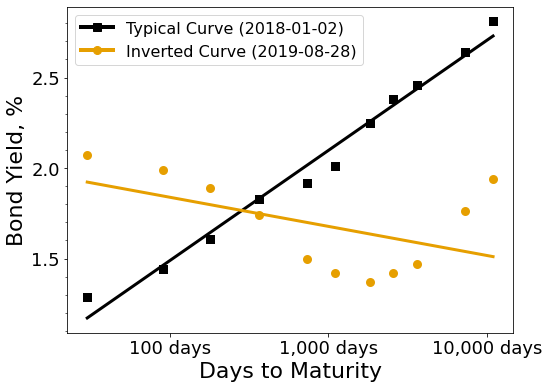

In [2]:
# Load the bonds
bonds = pd.read_csv('data/Bond_Yields.csv')

# Select interested dates
bonds.Date = pd.to_datetime(bonds['Date'])
all_months = ['2019-08-28','2018-01-02']
all_months = pd.to_datetime(all_months)
b = bonds.loc[bonds.Date == all_months[0]]
c = bonds.loc[bonds.Date == all_months[1]]

# Make a plot
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Pop columns with null data 
x_1 = list(b.columns)
x_1.pop(0)
x_1.pop(1)

# Get the associated values
all_tweets_1 = []
all_tweets_2 = []

for i in range(len(x_1)):
    all_tweets_1.append(b[x_1[i]].mean())
    all_tweets_2.append(c[x_1[i]].mean())
    #all_e.append(mean_confidence_interval(b[x_1[i]]))

# Get a list of x    
x = [30,90,180,365,730,1095,1825,2555,3650,7300,10950]
x = [np.log10(y) for y in x]
x_poly = []
for m in range(len(x)-1):
    if m == 0:
        x_a = 0
    else:
        x_a = x[m-1]
    x_b = x[m]
    for n in [.2,.4,.6,.8,1]:
        x_poly.append(x_a + (x_b - x_a) * n)
      
coef = np.polyfit(x,all_tweets_2,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_2, marker='s', color = "black",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='black',lw=3)
        
coef = np.polyfit(x,all_tweets_1,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_1, marker='o', color = "#E69F00",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='#E69F00',lw=3)


axs.set_ylabel("Bond Yield, %", fontsize = 22)
axs.set_xlabel("Days to Maturity", fontsize = 22)
custom_lines = [Line2D([0], [0], color='black',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#E69F00', lw=4, marker='o',ms=8)]
axs.legend(custom_lines,["Typical Curve ("+str(all_months[1])[:10]+')',"Inverted Curve ("+str(all_months[0])[:10]+')'],fontsize = 16)
axs.tick_params(labelsize=18)
axs.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
axs.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axs.xaxis.set_major_locator(mticker.MultipleLocator(1))
axs.set_xticklabels(('','100 days','1,000 days','10,000 days'))


plt.savefig("plots/Treasury-Bond_Yield-Curve.png",dpi=400)
plt.show()

In [3]:
df_bot_accounts = pd.read_csv('data/bots.csv')
df= pd.read_csv('data/tweets.csv')
df.created_at = pd.to_datetime(df['created_at'])

In [4]:
# Helper function to load a specific month
def get_range(t_1,t_2):
    
    df_range = df.copy()
    df_range.created_at = pd.to_datetime(df_range['created_at'])
    # Select only tweets in these dates
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_range['created_at']) & (df_range['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_range = df_range.loc[mask]

    return df_range

# Helper function for confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2, n-1)
    return h

# Helper function to get the counts of all dates
def get_counts():
    df_counts = pd.DataFrame({'created_at':[],'count':[], 'phrase':[]})

    # For each file
    for f in all_sents:

        # Read in a file
        df_temp = pd.read_csv(f)

        # Remove 0 sentiment:
        df_temp = df_temp.loc[df_temp['Sentiment'] != 0]
        
        # Drop duplicates if they exist
        df_temp = df_temp.drop_duplicates()
        
        # Get the phrase
        phrase = df_temp.phrase.values[0]

        # Change to date-time and group by date
        s = pd.to_datetime(df_temp['created_at'])
        df_temp = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
        df_temp['phrase'] = phrase
        
        df_counts = pd.concat([df_counts,df_temp])
    
    return df_counts

# Helper function to get log x values
def get_x():
    x_1 = [2,3,4,5,7,10,14,21,28,42,60,90,120,150,180,365,730,3*365,4*365,5*365,10*365,20*365,30*365]
    x = [np.log10(n) for n in x_1]  
    return(x)

In [5]:
print('N- tweets', df['ID'].count())
print('N- bots',df_bot_accounts.ID.count())
print('N- zero VADER', df.loc[df.vader == 0]['ID'].count())
df = df.loc[~df.ID.isin(list(df_bot_accounts.ID))]
df = df.loc[df.vader != 0]
print('Remaining',df.vader.count())

N- tweets 3568985
N- bots 122938
N- zero VADER 1267813
Remaining 2220462


In [6]:
for phrase in df.phrase.unique():
    print(phrase,df.loc[df.phrase == phrase].ID.count())

2 months 86198
10 days 99878
10 years 132512
12 months 16705
2 days 230441
2 weeks 236062
2 years 109415
20 years 84215
3 days 195239
3 months 85809
3 weeks 99853
3 years 97571
30 years 46387
4 days 110529
4 months 40575
4 weeks 27772
4 years 78585
5 days 105692
5 months 29382
5 years 123712
6 months 87406
6 weeks 22447
7 days 74077


In [7]:
df_main = df.loc[df.created_at < '2020-03-01']
print('Before March 2020 n =',df_main.vader.count())

all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']
x = get_x()
all_tweets = [df_main.loc[df_main['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef)
r = stats.pearsonr(x,all_tweets)
print(r)
print(r[0]**2)

Before March 2020 n = 1624426
(-0.7449767863968356, 4.5426133053754316e-05)
0.5549904122701564


In [8]:
all_months = ["2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]

df_main = df.copy()

# Get a list of the mean for each phrase for each month
all_phrases_2 = []
months = []
all_means = []

for i in range(len(all_months)-1):        
    # Get the appropriate month

    # Select only tweets in these dates
    mask = (pd.Timestamp(all_months[i]+' 00:00:00+0000') <= df_main['created_at']) & (df_main['created_at'] < pd.Timestamp(all_months[i + 1]+' 00:00:00+0000'))
    df_t = df_main.loc[mask]

    for phrase in all_phrases:
        months.append(all_months[i])
        all_phrases_2.append(phrase)
        all_means.append(df_t.loc[df_t['phrase'] == phrase].vader.mean())

df_stats = pd.DataFrame({'date':months,'phrase':all_phrases_2, 'mean':all_means})

x = get_x()
all_curves = []
all_means = []
mse = []
cors, ps = [], []

for i in range(len(all_months)-1):
    t_1 = all_months[i]
    t_2 = all_months[i+1]

    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_main['created_at']) & (df_main['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_t = df_main.loc[mask]
    all_means.append(df_t["vader"].mean())

    all_tweets = [df_t.loc[df_t['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
    coef = np.polyfit(x,all_tweets,1)
    all_curves.append(coef[0])
    poly1d_fn = np.poly1d(coef) 
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    mse.append(np.square(np.subtract(all_tweets,all_pred)).mean())

    r, p = stats.pearsonr(x,all_tweets)
    cors.append(round(r,2))
    ps.append(round(p,4))

    # How does increasing the number of coefficients affect curve?
    coef = np.polyfit(x,all_tweets,1)
    poly1d_fn = np.poly1d(coef) 
    all_pred = [poly1d_fn(x_1) for x_1 in x]
    r = np.corrcoef(all_pred, all_tweets)


df_curves = pd.DataFrame({'months':all_months[:len(all_months)-1],'curve':all_curves[:],
                          'means':all_means[:],'MSE_norm':mse,'cor_n':cors,'p_n':ps})

print('Monthly Cor Range',df_curves.loc[df_curves['months'] < '2020-03-01'].cor_n.min(),
      df_curves.loc[df_curves['months'] < '2020-03-01'].cor_n.max())
print('Monthly p range',df_curves.loc[df_curves['months'] < '2020-03-01'].p_n.min(),
      df_curves.loc[df_curves['months'] < '2020-03-01'].p_n.max())
print(df_curves.loc[df_curves['months'] < '2020-03-01'].cor_n.count())

Monthly Cor Range -0.82 -0.44
Monthly p range 0.0 0.0374
31


 
-0.03284 x + 0.2297
 
0.005104 x + 0.08982


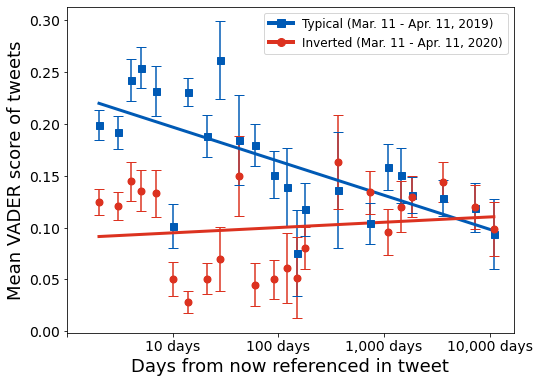

(0.14012202195519383, 0.523678981789085)


In [10]:
# Plot March 2019 and 2020
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Get all phrases and x locations in log of days
x = get_x()

# Plot 2019
df_main = get_range("2019-03-11", "2019-04-11") # 2018-03
all_tweets = [df_main.loc[df_main['phrase'] == phrase]['vader'].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase]['vader']) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='s', ecolor="#005AB5", mec="#005AB5", mfc="#005AB5", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#005AB5",lw=3)


# Plot 2020
df_main = get_range("2020-03-11", "2020-04-11") #2020 - 03-11
all_tweets = [df_main.loc[df_main['phrase'] == phrase]['vader'].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase]['vader']) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#DC3220", mec="#DC3220", mfc="#DC3220", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#DC3220",lw=3)

# Labels
plt.ylabel('Mean VADER score of tweets', fontsize = 18)
plt.xlabel("Days from now referenced in tweet", fontsize = 18)

custom_lines = [Line2D([0], [0], color='#005AB5',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#DC3220', lw=4,  marker='o',ms=8)]

axs.legend(custom_lines,["Typical (Mar. 11 - Apr. 11, 2019)","Inverted (Mar. 11 - Apr. 11, 2020)"],fontsize = 12)
plt.xticks(np.arange(5), ('','10 days', '100 days','1,000 days','10,000 days'))
axs.tick_params(labelsize=14)
plt.savefig('plots/Sentiment-Yield-Curve-Typical-Inverted-new.png',dpi=400)
plt.show()
print(stats.pearsonr(x,all_tweets))

39 39 39


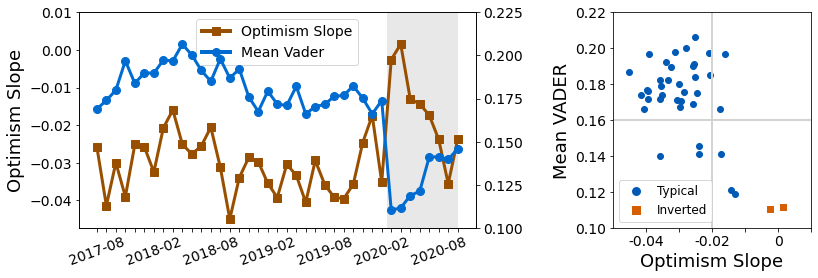

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(12,4.5),gridspec_kw={'width_ratios': [2, 1]})
fig.tight_layout(pad=2.5)

axs[0].axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs[0].plot(df_curves['months'],df_curves['curve'],marker='s',lw=3,markersize=8,color='#994F00')
axs[0].set_ylabel('Optimism Slope',fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_xticks(np.arange(39))
axs[0].set_yticks([-.04,-.03,-.02,-.01,0,.01])
axs[0].set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)

ax2 = axs[0].twinx()
ax2.plot(df_curves['months'],df_curves['means'],marker='o',lw=3,markersize=8,color='#006CD1')
#ax2.set_ylabel('Mean VADER',fontsize=16,rotation=270)
ax2.set_xticks(np.arange(39))
ax2.set_yticks([.1,.125,.15,.175,.2,.225])
ax2.tick_params(labelsize=14)

axs[0].set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)
custom_lines = [Line2D([0], [0], color='#994F00',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#006CD1', lw=4,  marker='o',ms=8)]

axs[0].legend(custom_lines,["Optimism Slope","Mean Vader"],fontsize = 14,loc='upper center')


axs[1].plot([-.02, -.02], [.1, .22], '-', color = '#d3d3d3', lw=2)
axs[1].plot([-.05, .02], [.16, .16], '-', color = '#d3d3d3', lw=2)

linear_rels = list(df_curves['curve'])
month_means_2 = list(df_curves['means'])
cols = ['#005AB5' for i in range(len(month_means_2) - 8)]
markers = ['o' for i in range(len(month_means_2) - 8)]
cols.append('#D55E00')
markers.append('s')
cols.append('#D55E00')
markers.append('s')
for i in range(6):
    cols.append('#005AB5')
    markers.append('o')
    
print(len(linear_rels),len(month_means_2),len(cols))
for i in range(len(month_means_2)):
    axs[1].scatter(linear_rels[i],month_means_2[i],color=cols[i],marker=markers[i])
    
axs[1].set_ylim([.1,.22])
axs[1].set_xlim([-.05,.005])
axs[1].set_ylabel('Mean VADER',fontsize=18)
axs[1].set_xlabel('Optimism Slope',fontsize=18)
axs[1].tick_params(labelsize=14)
custom_lines = [Line2D([0], [0], marker='o',color='w',markerfacecolor='#005AB5', markersize=10),
                Line2D([0], [0], marker='s',color='w',markerfacecolor='#D55E00', markersize=10)]
axs[1].legend(custom_lines,['Typical','Inverted'],loc='best',fontsize=12)
axs[1].set_xticks([-.04,-.03,-.02,-.01,.0,.01])
axs[1].set_xticklabels(['-0.04','','-0.02','','0'])
plt.tight_layout(pad=3)
plt.savefig("plots/Regular_OC_over_time.png",dpi=400)
plt.show()

In [12]:
df_temp = df_curves.copy()
df_temp = df_temp.loc[df_temp.months < "2020-03-01"]

df_curves['means_zscore'] = (df_curves['means'] - df_temp['means'].mean())/ df_temp['means'].std(ddof=0)
df_curves['curve_zscore'] = (df_curves['curve'] - df_temp['curve'].mean())/ df_temp['curve'].std(ddof=0)


print(df_curves['means'].min(), df_curves['means_zscore'].min())
print(df_curves['curve'].max(), df_curves['curve_zscore'].max())

0.11033045238887039 -6.424867500863522
0.001537745031108239 4.513905962745206


/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.


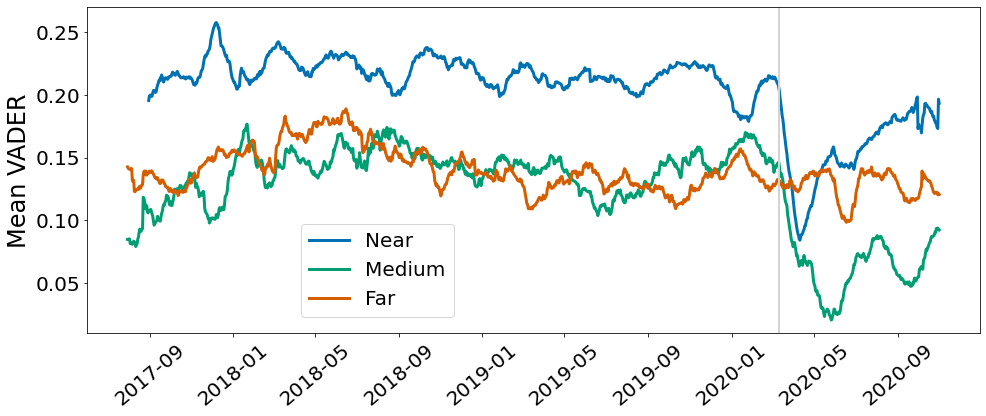

In [13]:
p_d = ['2 days','3 days','4 days','5 days','7 days','10 days','2 weeks','3 weeks','4 weeks']
p_w = ['6 weeks','2 months','3 months','4 months','5 months','6 months']
p_m = ['12 months','2 years','3 years','4 years','5 years','10 years','20 years','30 years']
a = ['Near','Medium','Far']
ps = [p_d,p_w,p_m]
df_counts = pd.DataFrame({'created_at':[],'vader':[],'phrase':[]})
for p in range(len(ps)):
    df_temp = df.loc[df.phrase.isin(ps[p])]
    df_temp = df_temp[['created_at','vader']].resample('d', on='created_at').mean().dropna(how='all')
    df_temp.Sentiment = (df_temp['vader'] - df_temp['vader'].mean())/df_temp['vader'].std(ddof=0)
    df_temp['phrase'] = a[p]
    df_temp['created_at'] = df_temp.index
    df_temp = df_temp.reset_index(drop=True)
    df_counts = pd.concat([df_counts,df_temp],sort=False)
df_counts = df_counts.iloc[31:]
    
fig, axs = plt.subplots(1, 1,figsize=(16,6))
df_2 = df_counts.loc[df_counts.phrase == 'Near'][['created_at','vader']]
df_2['MA'] = df_2.rolling(window=30).mean()
axs.plot(df_2['created_at'],df_2['MA'], label='Near',color = '#0072B2',lw=3)

df_2 = df_counts.loc[df_counts.phrase == 'Medium'][['created_at','vader']]
df_2['MA'] = df_2.rolling(window=30).mean()
axs.plot(df_2['created_at'],df_2['MA'], label='Medium',color = '#009E73', lw=3)

df_2 = df_counts.loc[df_counts.phrase == 'Far'][['created_at','vader']]
df_2['MA'] = df_2.rolling(window=30).mean()
axs.plot(df_2['created_at'],df_2['MA'], label='Far', color = '#D55E00', lw=3)

axs.set_ylim([.01,.27])
axs.plot([pd.to_datetime('2020-03-11 00:00:00+00:00'), pd.to_datetime('2020-03-11 00:00:00+00:00')], [0, .28], '-', color = '#d3d3d3', lw=2)


axs.set_ylabel('Mean VADER',fontsize=24)
axs.legend(fontsize=20, loc=(.24,.05))
for label in axs.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('center')

axs.tick_params(labelsize=20)
plt.savefig('plots/Mean-Vader-near-med-far.png',dpi=400,bbox_inches='tight')
plt.show()

In [14]:
m_vader, counts, phrases, month = [], [], [], []

# Load the data file for every phrase & get only tweets with some vader
for phrase in all_phrases:
    df_temp = df.loc[df.phrase == phrase]

    for m in range(len(all_months)-1):
        
        # Look at each month individually 
        mask = (pd.Timestamp(all_months[m]+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(all_months[m+1]+' 00:00:00+0000'))
        df_main = df_temp.loc[mask]
        
        # Store mean vader, fear, concreteness, count, and phrase
        m_vader.append(df_main.vader.mean())
        counts.append(df_main.vader.count())
        phrases.append(phrase)
        month.append(all_months[m])

df_months = pd.DataFrame({'month_VADER':m_vader,'count':counts,'phrase':phrases,'month':month})


df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2 days') | (df_temp.phrase == '3 days') | (df_temp.phrase == '4 days') | (df_temp.phrase == '5 days') | (df_temp.phrase == '7 days') | (df_temp.phrase == '10 days') | (df_temp.phrase == '2 Weeks') | (df_temp.phrase == '3 weeks') | (df_temp.phrase == '4 weeks')]
med = df_temp.loc[(df_temp.phrase == '6 weeks') | (df_temp.phrase == '2 months') | (df_temp.phrase == '3 months') | (df_temp.phrase == '4 months') | (df_temp.phrase == '5 months') | (df_temp.phrase == '6 months')]
far = df_temp.loc[(df_temp.phrase == '12 months') | (df_temp.phrase == '2 years') | (df_temp.phrase == '3 years') | (df_temp.phrase == '4 years') | (df_temp.phrase == '5 years') | (df_temp.phrase == '10 years') | (df_temp.phrase == '20 years') | (df_temp.phrase == '30 years')]
print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))

df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())

near = df_temp.loc[(df_temp.phrase == '2 days') | (df_temp.phrase == '3 days') | (df_temp.phrase == '4 days') | (df_temp.phrase == '5 days') | (df_temp.phrase == '7 days') | (df_temp.phrase == '10 days') | (df_temp.phrase == '2 Weeks') | (df_temp.phrase == '3 weeks') | (df_temp.phrase == '4 weeks')]
med = df_temp.loc[(df_temp.phrase == '6 weeks') | (df_temp.phrase == '2 months') | (df_temp.phrase == '3 months') | (df_temp.phrase == '4 months') | (df_temp.phrase == '5 months') | (df_temp.phrase == '6 months')]
far = df_temp.loc[(df_temp.phrase == '12 months') | (df_temp.phrase == '2 years') | (df_temp.phrase == '3 years') | (df_temp.phrase == '4 years') | (df_temp.phrase == '5 years') | (df_temp.phrase == '10 years') | (df_temp.phrase == '20 years') | (df_temp.phrase == '30 years')]

print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))


Skew -0.04985707259864343
Kurtosis -0.38651877864228235 Count 713
Near: 0.22240164269945628
Med: 0.14807628860281832
far: 0.14240923092299654
all F_onewayResult(statistic=293.2461538456304, pvalue=1.5947214872207374e-92)
n-m F_onewayResult(statistic=359.017479463084, pvalue=1.0246655583310203e-58)
n-f F_onewayResult(statistic=535.4242557310729, pvalue=8.624643306495182e-81)
m-f F_onewayResult(statistic=1.9206608527193716, pvalue=0.1664988003655302)
Skew -0.01020858931543035
Kurtosis 0.04593246194261713 Count 184
Near: 0.16688358425541877
Med: 0.06907913007611026
far: 0.12618459580466698
all F_onewayResult(statistic=81.0716077377721, pvalue=1.4406402459411794e-25)
n-m F_onewayResult(statistic=124.91001932633777, pvalue=7.78162669048913e-20)
n-f F_onewayResult(statistic=34.271021815993564, pvalue=3.90516622763169e-08)
m-f F_onewayResult(statistic=73.3815631345963, pvalue=7.337422696641015e-14)
